In [1]:
import findspark 
findspark.init()

In [2]:
import pyspark
from pyspark.context import SparkContext 
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
print(sc.version)
print(spark.version)

2.4.8
2.4.8


In [3]:
# Load the data from MongoDB
spark = SparkSession.builder.appName("mongodbtest1").master('local').config("spark.mongodb.input.uri", "mongodb://localhost:27018/Bank_database.Bank_Churners").config("spark.mongodb.output.uri", "mongodb://localhost:27018/Bank_database.Bank_Churners").config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1').getOrCreate()
    
original_bank_df = spark.read.format('com.mongodb.spark.sql.DefaultSource').option( "uri", "mongodb://localhost:27018/Bank_database.Bank_Churners").load()    

In [4]:
# Make a duplicate dataframe for analysis
bank_df = original_bank_df
bank_df.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)
 |-- CLIENTNUM: integer (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (n

In [5]:
# Drop the useless columns
drop_columns = ['CLIENTNUM','_id']
bank_df = bank_df.drop(*drop_columns)
bank_df.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)



In [6]:
# Drop null values
bank_df=bank_df.na.drop()

In [7]:
# Transform data to parquet
bank_df.write.mode('overwrite').parquet("C:/Final_Project/bankChurners.parquet")
bank_df = spark.read.parquet("C:/Final_Project/bankChurners.parquet")
bank_df.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)



### Data Exploration

In [8]:
import pandas as pd
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import seaborn as sns

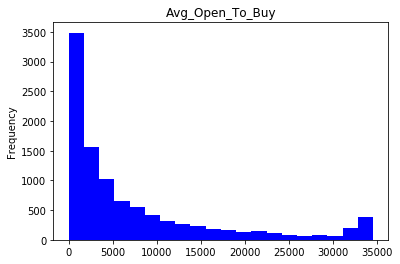

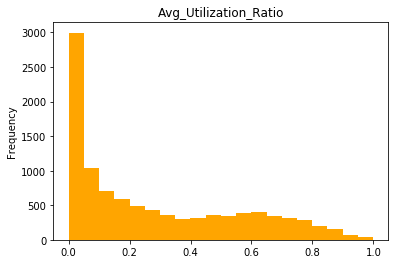

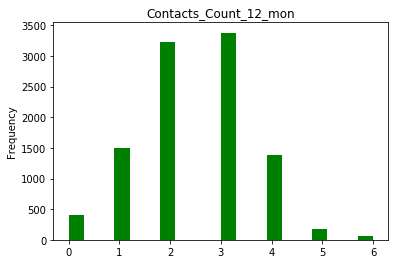

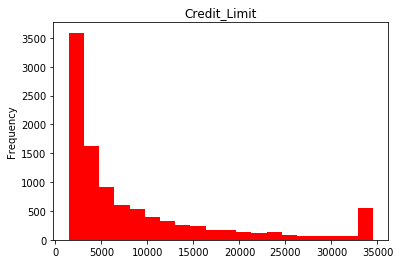

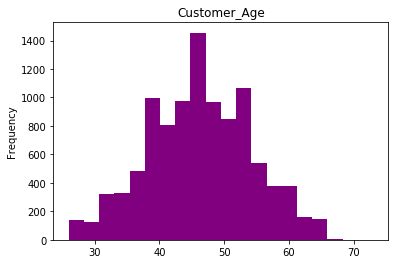

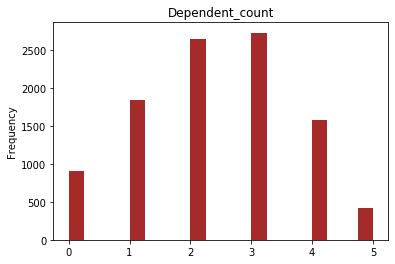

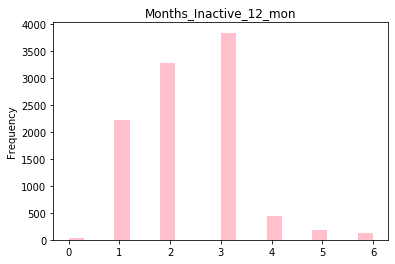

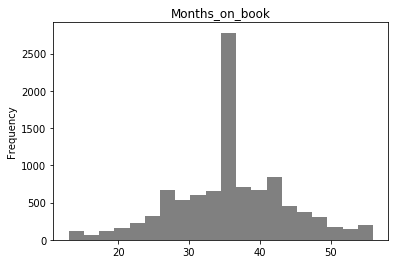

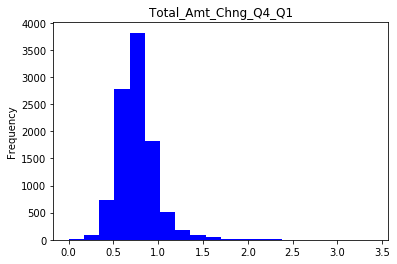

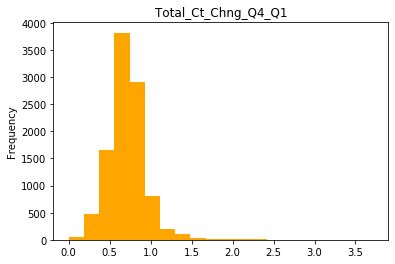

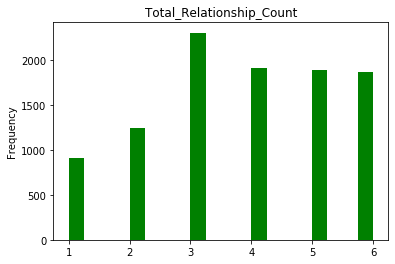

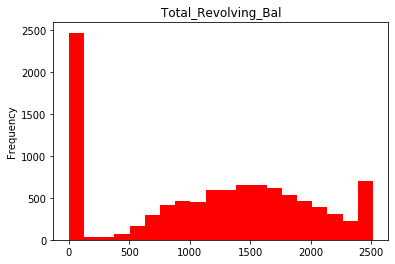

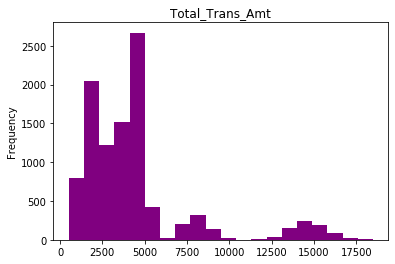

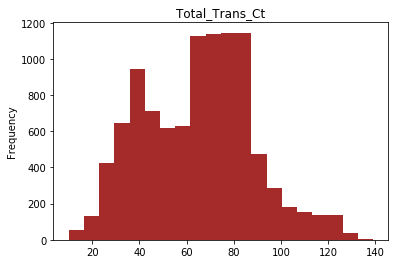

In [11]:
# Exploration of numerical columns
numerical_columns = [c for c,t in bank_df.dtypes if t in ['double', 'int']]

numerical_columns_df = bank_df.select(numerical_columns).toPandas()

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

for i, col in enumerate(numerical_columns_df.columns):
    plt.figure()
    pd_df[col].plot.hist(bins=20,color=colors[i % len(colors)])
    plt.title(col)
    plt.show()

In [17]:
# Exploration of categorical columns

grouped_df_income_category = bank_df.groupBy("Income_category", "Attrition_Flag").agg(F.count("*").alias("count"))

pdf_income_category = grouped_df_income_category.toPandas()

pdf_income_category = pdf_income_category.pivot(index="Income_category", columns="Attrition_Flag", values="count")
pdf_income_category

Attrition_Flag,Attrited Customer,Existing Customer
Income_category,,
$120K +,126,601
$40K - $60K,271,1519
$60K - $80K,189,1213
$80K - $120K,242,1293
Less than $40K,612,2949
Unknown,187,925


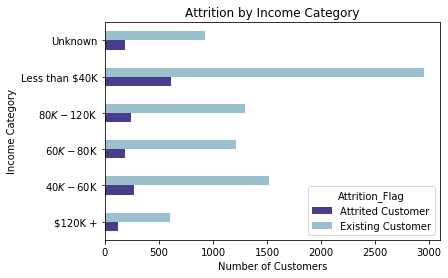

In [18]:
#Plot the graph
colors = ["#483D8B", "#9AC0CD"]
pdf_income_category.plot(kind="barh",color=colors)
plt.title("Attrition by Income Category")
plt.xlabel("Number of Customers")
plt.ylabel("Income Category")
plt.show()

In [19]:
grouped_df_education_level = bank_df.groupBy("Education_Level", "Attrition_Flag").agg(F.count("*").alias("count"))

pdf_education_level = grouped_df_education_level.toPandas()

pdf_education_level = pdf_education_level.pivot(index="Education_Level", columns="Attrition_Flag", values="count")
pdf_education_level

Attrition_Flag,Attrited Customer,Existing Customer
Education_Level,,
College,154,859
Doctorate,95,356
Graduate,487,2641
High School,306,1707
Post-Graduate,92,424
Uneducated,237,1250
Unknown,256,1263


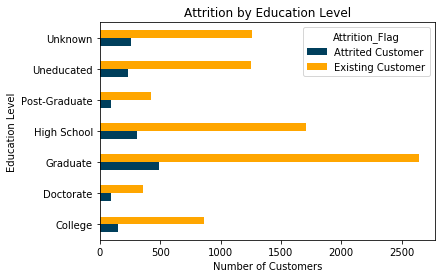

In [20]:
# Plot the graph
colors = ["#003f5c", "#ffa600"]
pdf_education_level.plot(kind="barh",color=colors)
plt.title("Attrition by Education Level")
plt.xlabel("Number of Customers")
plt.ylabel("Education Level")
plt.show()

In [21]:
grouped_df_gender = bank_df.groupBy("Gender", "Attrition_Flag").agg(F.count("*").alias("count"))

pdf_education_gender = grouped_df_gender.toPandas()

pdf_education_gender = pdf_education_gender.pivot(index="Gender", columns="Attrition_Flag", values="count")
pdf_education_gender

Attrition_Flag,Attrited Customer,Existing Customer
Gender,,
F,930,4428
M,697,4072


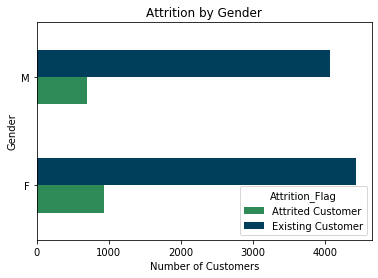

In [22]:
# Plot the graph
colors = ["seagreen","#003f5c"]
pdf_education_gender.plot(kind="barh",color=colors)
plt.title("Attrition by Gender")
plt.xlabel("Number of Customers")
plt.ylabel("Gender")
plt.show()

In [23]:
grouped_df_card_category = bank_df.groupBy("Card_Category", "Attrition_Flag").agg(F.count("*").alias("count"))

pdf_education_card_category = grouped_df_card_category.toPandas()

pdf_education_card_category = pdf_education_card_category.pivot(index="Card_Category", columns="Attrition_Flag", values="count")
pdf_education_card_category

Attrition_Flag,Attrited Customer,Existing Customer
Card_Category,,
Blue,1519,7917
Gold,21,95
Platinum,5,15
Silver,82,473


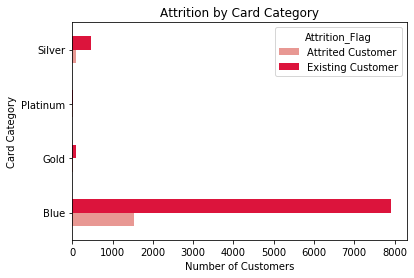

In [24]:
# Plot the graph
colors = ["#E89893","#DC143C"]
pdf_education_card_category.plot(kind="barh",color=colors)
plt.title("Attrition by Card Category")
plt.xlabel("Number of Customers")
plt.ylabel("Card Category")
plt.show()

In [25]:
grouped_df_marital_status = bank_df.groupBy("Marital_Status", "Attrition_Flag").agg(F.count("*").alias("count"))

pdf_education_marital_status = grouped_df_marital_status.toPandas()

pdf_education_marital_status = pdf_education_marital_status.pivot(index="Marital_Status", columns="Attrition_Flag", values="count")
pdf_education_marital_status

Attrition_Flag,Attrited Customer,Existing Customer
Marital_Status,,
Divorced,121,627
Married,709,3978
Single,668,3275
Unknown,129,620


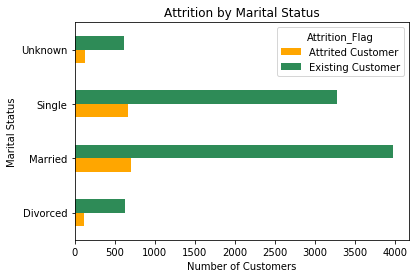

In [26]:
# Plot the graph
colors = ["#ffa600","seagreen"]
pdf_education_marital_status.plot(kind="barh",color=colors)
plt.title("Attrition by Marital Status")
plt.xlabel("Number of Customers")
plt.ylabel("Marital Status")
plt.show()

### Is there any feasible relationship between Marital status and Average utilization Ratio?

In [27]:
summary_df = bank_df.groupBy('Marital_Status').agg(
    round(min('Avg_Utilization_Ratio'), 2).alias('Min_Avg_Utilization_Ratio'),
    round(mean('Avg_Utilization_Ratio'), 2).alias('Mean_Avg_Utilization_Ratio'),
    round(max('Avg_Utilization_Ratio'), 2).alias('Max_Avg_Utilization_Ratio'))

# summary statistics
summary_df.show()

+--------------+-------------------------+--------------------------+-------------------------+
|Marital_Status|Min_Avg_Utilization_Ratio|Mean_Avg_Utilization_Ratio|Max_Avg_Utilization_Ratio|
+--------------+-------------------------+--------------------------+-------------------------+
|       Unknown|                      0.0|                      0.26|                     0.96|
|       Married|                      0.0|                      0.29|                     0.99|
|      Divorced|                      0.0|                      0.26|                      1.0|
|        Single|                      0.0|                      0.26|                      1.0|
+--------------+-------------------------+--------------------------+-------------------------+



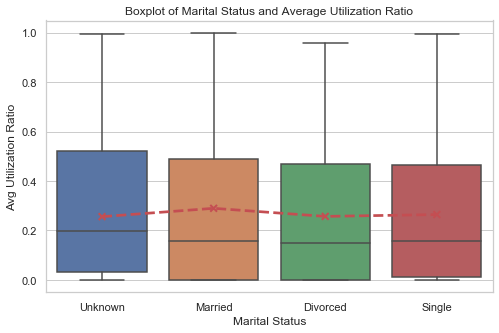

In [28]:
mean_df = bank_df.groupBy("Marital_Status").agg(mean("Avg_Utilization_Ratio").alias("Avg_Utilization_Ratio_mean"))

# Plot the boxplot
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="Marital_Status", y="Avg_Utilization_Ratio", data=bank_df.toPandas(), ax=ax)
sns.pointplot(x="Marital_Status", y="Avg_Utilization_Ratio_mean", data=mean_df.toPandas(), color="r", markers="x", linestyles="--", ax=ax)
plt.title("Boxplot of Marital Status and Average Utilization Ratio")
plt.xlabel("Marital Status")
plt.ylabel("Avg Utilization Ratio")
plt.show()

### Data Cleaning

In [29]:
# String Indexing
from pyspark.ml.feature import StringIndexer
    
cat_cols = ['Attrition_Flag','Gender']
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_index')
    bank_df = indexer.fit(bank_df).transform(bank_df)
        
# String Indexing for Ordinal data   
bank_df = bank_df.withColumn("Education_Level_index",\
                              when((bank_df.Education_Level == 'Uneducated'), lit(0))\
                             .when((bank_df.Education_Level == 'High School'), lit(1))\
                             .when((bank_df.Education_Level == 'College'), lit(2))\
                             .when((bank_df.Education_Level == 'Unknown'), lit(3))\
                             .when((bank_df.Education_Level == 'Graduate'), lit(4))\
                             .when((bank_df.Education_Level == 'Post-Graduate'), lit(5))\
                             .when((bank_df.Education_Level == 'Doctorate'), lit(6)))

bank_df = bank_df.withColumn("Income_Category_index",\
                              when((bank_df.Income_Category == 'Less than $40K'), lit(0))\
                             .when((bank_df.Income_Category == '$40K - $60K'), lit(1))\
                             .when((bank_df.Income_Category == '$60K - $80K'), lit(2))\
                             .when((bank_df.Income_Category == 'Unknown'), lit(3))\
                             .when((bank_df.Income_Category == '$80K - $120K'), lit(4))\
                             .when((bank_df.Income_Category == '$120K +'), lit(5)))

In [30]:
# Split the nominal data into multiple columns to avoid giving weights to the levels
bank_df = bank_df.withColumn("Gender_Male",when((bank_df.Gender == 'M'), lit(1)).otherwise(lit(0)))
bank_df = bank_df.withColumn("Gender_Female",when((bank_df.Gender == 'M'), lit(1)).otherwise(lit(0)))

bank_df = bank_df.withColumn("Platinum_Card",when((bank_df.Card_Category == 'Platinum'), lit(1)).otherwise(lit(0)))
bank_df = bank_df.withColumn("Blue_Card",when((bank_df.Card_Category == 'Blue'), lit(1)).otherwise(lit(0)))
bank_df = bank_df.withColumn("Silver_Card",when((bank_df.Card_Category == 'Silver'), lit(1)).otherwise(lit(0)))
bank_df = bank_df.withColumn("Gold_Card",when((bank_df.Card_Category == 'Gold'), lit(1)).otherwise(lit(0)))

bank_df = bank_df.withColumn("MS_Single",when((bank_df.Marital_Status == 'Single'), lit(1)).otherwise(lit(0)))
bank_df = bank_df.withColumn("MS_Married",when((bank_df.Marital_Status == 'Married'), lit(1)).otherwise(lit(0)))
bank_df = bank_df.withColumn("MS_Divorced",when((bank_df.Marital_Status == 'Divorced'), lit(1)).otherwise(lit(0)))
bank_df = bank_df.withColumn("MS_Unknown",when((bank_df.Marital_Status == 'Unknown'), lit(1)).otherwise(lit(0)))

In [31]:
# Drop the columns that are not necessary for correlation and modeling
drop_columns = ['Attrition_Flag','Avg_Open_To_Buy','Avg_Utilization_Ratio','Card_Category',
                'Education_Level','Gender','Income_Category','Marital_Status']
bank_df_clean = bank_df.drop(*drop_columns)
bank_df_clean.printSchema()

root
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Attrition_Flag_index: double (nullable = false)
 |-- Gender_index: double (nullable = false)
 |-- Education_Level_index: integer (nullable = true)
 |-- Income_Category_index: integer (nullable = true)
 |-- Gender_Male: integer (nullable = false)
 |-- Gender_Female: integer (nullable = false)
 |-- Platinum_Card: integer (nullable = false)
 |-- Blue_Card: integer (nullable = false)
 |-- Si

### What factors is the credit limit depend on?

In [32]:
def correlation_matrix(df, correlation_columns):
    df_num = df.select(correlation_columns)

    correlation_list = []
    for col1 in correlation_columns:
        correlation_row = []
        for col2 in correlation_columns:
            correlation_value = df_num.stat.corr(col1, col2)
            correlation_row.append(correlation_value)
        correlation_list.append(correlation_row)

    corr_df = pd.DataFrame(correlation_list, columns=correlation_columns, index=correlation_columns)
    return corr_df

columns_excluded = ['Attrition_Flag_index', 'Gender_Male', 'Gender_Female']
correlation_columns = [col for col in bank_df_clean.columns if col not in columns_excluded]
corr_df = correlation_matrix(bank_df_clean, correlation_columns)

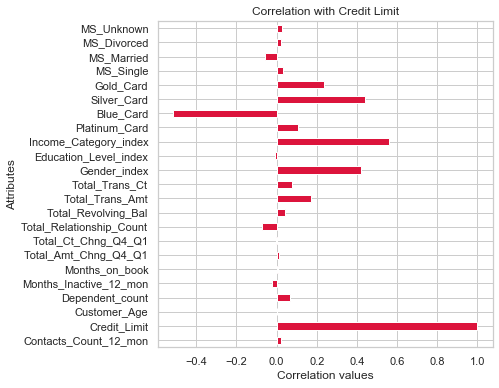

In [33]:
# Credit limit correlation with other variables
credit_limit_corr = corr_df.loc['Credit_Limit', :]

# Plot the graph
fig, ax = plt.subplots(figsize=(6, 6))
credit_limit_corr.plot(kind='barh', color='#DC143C')
plt.title('Correlation with Credit Limit')
plt.xlabel('Correlation values')
plt.ylabel('Attributes')
plt.show()

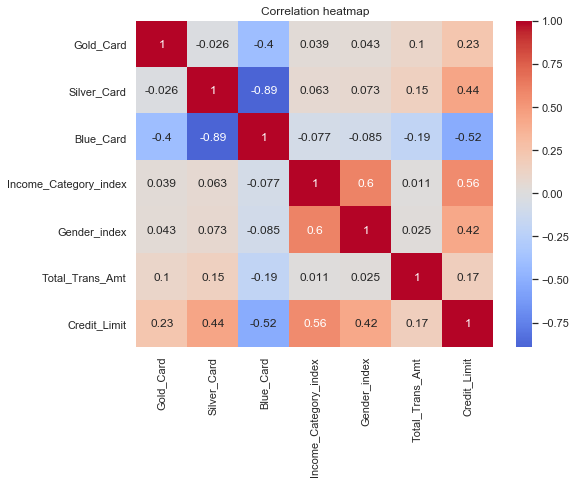

In [34]:
# Select the variables that are having correlation greater than 0.1 and less than -0.1 
significant_cols = ['Gold_Card', 'Silver_Card', 'Blue_Card', 'Income_Category_index', 'Gender_index', 'Total_Trans_Amt', 'Credit_Limit']

credit_corr = correlation_matrix(bank_df_clean,significant_cols)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(credit_corr, cmap="coolwarm", annot=True, center=0, ax=ax)
plt.title("Correlation heatmap")
plt.show()

### Can existing customer attrition be anticipated using current existing customers and attritted customers?

In [35]:
# Vector Assembler
from pyspark.ml.feature import VectorAssembler

columns_excluded = ['Attrition_Flag_index', 'Gender_Index']
inputCols = [col for col in bank_df_clean.columns if col not in columns_excluded]

pred_vector_assembler = VectorAssembler(inputCols = inputCols, outputCol = 'features')
assembled_bank_df = pred_vector_assembler.transform(bank_df_clean)

In [36]:
# Split the data into training and testing data
train_df, test_df = assembled_bank_df.randomSplit([0.8,0.2], seed = 70)

In [37]:
# LOGISTIC REGRESSION

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'Attrition_Flag_index')
lr_model = lr.fit(train_df)

# Prediction
lr_pred = lr_model.transform(test_df)
lr_pred.select('prediction', 'Attrition_Flag_index').show()

+----------+--------------------+
|prediction|Attrition_Flag_index|
+----------+--------------------+
|       0.0|                 0.0|
|       1.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 1.0|
|       1.0|                 1.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       1.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
+----------+--------------------+
only showing top 20 rows



In [38]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import StructType, StructField, StringType, FloatType

lr_metrics = MulticlassMetrics(lr_pred['Attrition_Flag_index','prediction'].rdd)

lr_metric_labels = [("Accuracy", lr_metrics.accuracy),
           ("Precision", lr_metrics.precision(1.0)),
           ("Recall", lr_metrics.recall(1.0)),
           ("Fmeasure", lr_metrics.fMeasure(1.0)),
           ("True Positive Rate", lr_metrics.truePositiveRate(1.0)),
           ("False Positive Rate", lr_metrics.falsePositiveRate(1.0))]

schema = StructType([
    StructField("Metric", StringType(), True),
    StructField("Value", FloatType(), True)
])

lr_metrics_df = spark.createDataFrame(lr_metric_labels, schema)
lr_metrics_df.show()

+-------------------+-----------+
|             Metric|      Value|
+-------------------+-----------+
|           Accuracy| 0.88994974|
|          Precision|  0.5766871|
|             Recall|  0.6988848|
|           Fmeasure|  0.6319328|
| True Positive Rate|  0.6988848|
|False Positive Rate|0.080185935|
+-------------------+-----------+



In [39]:
# RANDOM FOREST REGRESSION

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Attrition_Flag_index')
rf_model = rf.fit(train_df)

# Prediction
rf_pred = rf_model.transform(test_df)
rf_pred.select('prediction', 'Attrition_Flag_index').show()

+----------+--------------------+
|prediction|Attrition_Flag_index|
+----------+--------------------+
|       0.0|                 0.0|
|       1.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 1.0|
|       1.0|                 1.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       1.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
+----------+--------------------+
only showing top 20 rows



In [40]:
rf_metrics = MulticlassMetrics(rf_pred['Attrition_Flag_index','prediction'].rdd)

rf_metric_labels = [("Accuracy", rf_metrics.accuracy),
           ("Precision", rf_metrics.precision(1.0)),
           ("Recall", rf_metrics.recall(1.0)),
           ("Fmeasure", rf_metrics.fMeasure(1.0)),
           ("True Positive Rate", rf_metrics.truePositiveRate(1.0)),
           ("False Positive Rate", rf_metrics.falsePositiveRate(1.0))]

rf_metrics_df = spark.createDataFrame(rf_metric_labels, schema)
rf_metrics_df.show()

+-------------------+----------+
|             Metric|     Value|
+-------------------+----------+
|           Accuracy| 0.9075377|
|          Precision|       0.5|
|             Recall|0.88586956|
|           Fmeasure| 0.6392157|
| True Positive Rate|0.88586956|
|False Positive Rate|0.09025471|
+-------------------+----------+

